In [1]:
import time
import io
import functools
import pathlib
import glob
from typing import Callable, List
from PIL import Image

import numpy as np
import pandas as pd
import torch
from torchvision.io import read_image
from torchvision.io import ImageReadMode
import matplotlib.pyplot as plt

In [2]:
IMG_PATH = "/home/zachcoleman/burnt-ends/data/coco/imgs/val"
IMG_SIZE = (512, 512)

In [3]:
class ImageDataset:
    def __init__(self, img_dir, transforms: List[Callable] = None, ext = "jpg"):
        self.filepaths = glob.glob(str(pathlib.Path(img_dir) / f"*.{ext}"))
        if transforms is None:
            self.transforms = []
        else:
            self.transforms = transforms
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        img_tens = read_image(self.filepaths[idx], mode=ImageReadMode.RGB)
        for t in self.transforms:
            img_tens = t(img_tens)
        return img_tens
    
    @classmethod
    def plot(cls, x, ax = None):
        if ax is None:
            return plt.imshow(x.permute([1, 2, 0]).numpy())
        else:
            return ax.imshow(x.permute([1, 2, 0]).numpy())

In [4]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, multiply_expand_factor):
        super().__init__()
        self.encode_layers = [
            torch.nn.Conv2d(3, 32, 7, 2, 3),
            torch.nn.Conv2d(32, 64, 5, 2, 2),
            torch.nn.Conv2d(64, 6, 1, 1, "same"),
        ]
        self.decode_layers = [
            torch.nn.ConvTranspose2d(6, 16, 4, 2, 1),
            torch.nn.ConvTranspose2d(16, 32, 4, 2, 1),
            torch.nn.Conv2d(32, 3, 1, 1, "same")
        ]
        self.encode_layers = torch.nn.ModuleList(self.encode_layers)
        self.decode_layers = torch.nn.ModuleList(self.decode_layers)
        self.multiply_expand_factor = multiply_expand_factor

    def get_compression_ratio(self):
        tmp = torch.randn(1, 3, 512, 512, device=next(self.parameters()).device)
        compressed = self.compress(tmp)
        data_pts = lambda l: functools.reduce(lambda x, y: x*y, l)
        return  data_pts(compressed.shape) / data_pts(tmp.shape)
    
    def encode(self, inputs) -> torch.Tensor:
        feature_maps = inputs
        for l in self.encode_layers:
            feature_maps = l(feature_maps)
        return feature_maps
    
    def decode(self, feature_maps) -> torch.Tensor:
        x = feature_maps
        for l in self.decode_layers:
            x = l(x)
        return x

    def quantize(self, inputs) -> torch.Tensor:
        return torch.round(inputs)

    def compress(self, inputs) -> torch.Tensor:
        x = self.encode(inputs)
        x = x * self.multiply_expand_factor
        x = self.quantize(x)
        return x

    def decompress(self, feature_maps) -> torch.Tensor:
        x = self.decode(feature_maps)
        x = torch.clamp(x, 0., 1.)
        return x

    def forward(self, inputs):
        x = self.encode(inputs)
        x = x * self.multiply_expand_factor
        x = self.decode(x)
        x = torch.clamp(x, 0., 1.)
        return x

    def compress_decompress(self, inputs):
        x = self.compress(inputs)
        x = self.decompress(x)
        return x

In [5]:
num_of_epochs = 1
batch_size = 32
down_time = 0.15
num_sleeps = 2

In [6]:
resize = lambda x: torch.nn.functional.interpolate(x.unsqueeze(0), size=IMG_SIZE)[0]
normalize = lambda x: x / 255.

ds = ImageDataset(IMG_PATH, [resize, normalize])
dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True
)

auto_encoder = AutoEncoder(multiply_expand_factor=100)
auto_encoder.to("cuda")
# loss_fn = torch.nn.L1Loss()
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(auto_encoder.parameters())

for epoch_num in range(num_of_epochs):
    iter_data_loader = iter(dataloader)
    start_time = time.perf_counter()
    for n, X in enumerate(iter_data_loader):
        optim.zero_grad()
        X = X.to("cuda")
        output = auto_encoder(X)
        loss = loss_fn(output, X)
        if (n+1) % 100 == 0:
            stop_time = time.perf_counter()
            print(f"epoch: {epoch_num+1} - step: {n+1}th - time: {stop_time-start_time:.2f}s - loss: {loss:.4f}")
            start_time = time.perf_counter()
        time.sleep(down_time / num_sleeps)
        loss.backward()
        optim.step()
        time.sleep(down_time / num_sleeps)

epoch: 1 - step: 100th - time: 27.94s - loss: 0.0076


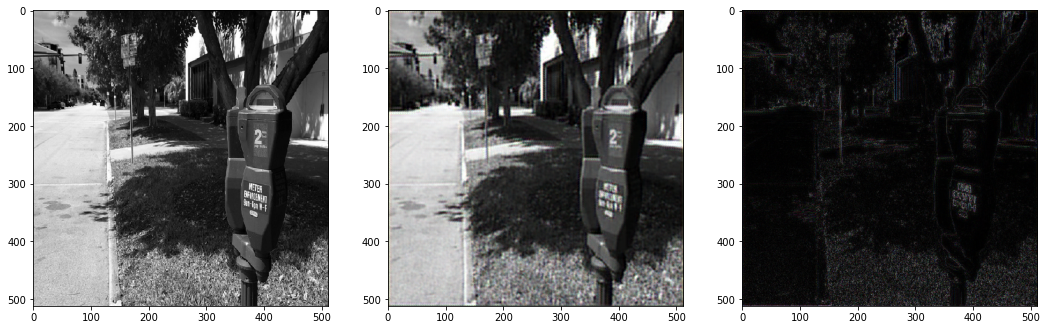

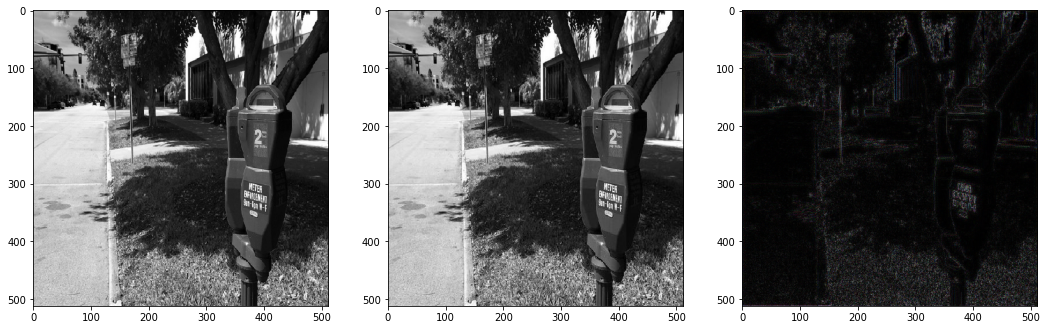

In [7]:
ix = np.random.randint(0, len(ds))

# visualize AutoEncoder compression
fig, ax = plt.subplots(1, 3, figsize=(18, 12))
ds.plot(ds[ix], ax[0])
with torch.inference_mode():
    tmp = auto_encoder.compress_decompress(ds[ix].unsqueeze(0).to("cuda"))[0].cpu()
ds.plot(tmp, ax[1])
ds.plot(torch.abs(tmp - ds[ix]), ax[2])
plt.show()

# visualize JPEG compression
fig, ax = plt.subplots(1, 3, figsize=(18, 12))
ds.plot(ds[ix], ax[0])

# JPEG encode and decode
output =  io.BytesIO()
Image.fromarray((ds[ix].numpy().transpose([1, 2, 0]) * 255).astype(np.uint8)).save(output, format="JPEG")
img = Image.open(io.BytesIO(output.getvalue()))
ax[1].imshow(img)

jpg_tensor = normalize(torch.from_numpy(np.array(img).transpose(2, 0, 1)))
ds.plot(torch.abs(tmp - jpg_tensor), ax[2])
plt.show()

In [8]:
auto_encoder.get_compression_ratio()

0.125

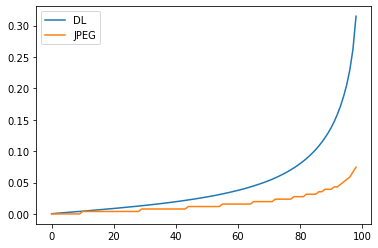

In [9]:
plt.plot(
    np.quantile(torch.abs(tmp - ds[ix]).cpu().numpy(), 
    np.arange(0.01, 1, 0.01)),
    label="DL"
)
plt.plot(
    np.quantile(torch.abs(jpg_tensor - ds[ix]).cpu().numpy(),
    np.arange(0.01, 1, 0.01)),
    label="JPEG"
)
plt.gca().legend()
plt.show()